# Notebook para clusterização de títulos de produções acadêmicas

Este notebook tem como objetivo agrupar títulos de produções acadêmicas por similaridade de temas, utilizando técnicas de NLP e algoritmos de clusterização. O processo será dividido em etapas, desde a importação dos dados até a visualização dos grupos formados.

## 1. Importar Bibliotecas Necessárias

Vamos importar as principais bibliotecas para manipulação de dados, processamento de texto, clusterização e visualização. 

In [45]:
# Manipulação de dados
import pandas as pd
import numpy as np
from kneed import KneeLocator

# Processamento de texto
import re
import string
import nltk
from nltk.corpus import stopwords

# Vetorização e clusterização
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering

# Redução de dimensionalidade e visualização
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Baixar recursos do NLTK se necessário
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sofip\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 2. Carregar e Visualizar os Dados dos Títulos

Vamos carregar o arquivo JSON com os títulos e exibir uma amostra para inspeção inicial.

In [46]:
# Carregar os títulos do arquivo JSON
import json

with open("../data/titulos_producoes.json", encoding="utf-8") as f:
    data = json.load(f)

titulos = data["titulos"]
df = pd.DataFrame({"titulo": titulos})

# Exibir as primeiras linhas
df.head(10)

titulo
0  Supporting the choice of the best-fit agile mo...
1  Descrevendo o uso dos computadores nas escolas...
2  Testing real-time systems from compositional s...
3  A Mechanized Strategy for Safe Abstraction of ...
4  SELECIONANDO MODELOS DE SOFTWARE AUTOMATICAMEN...
5  Programa ?Servidoras que Transformam? - Cursos...
6  Engenharia de Software com metodologias ativas...
7  Análise dos motivos para o desuso de recursos ...
8  Ensinando o pensamento computacional usando li...
9  A multicriteria approach for selection of agil...

## 3. Pré-processamento dos Títulos

Nesta etapa, vamos limpar os textos: transformar em minúsculas, remover pontuação, stopwords e aplicar lematização ou stemming.

In [47]:
# Função de pré-processamento
def preprocess_text(text):
    # Minúsculas
    text = text.lower().split(".")[0]  # Pega apenas a primeira frase
    # Remover pontuação
    text = text.translate(str.maketrans("", "", string.punctuation))
    # Remover números
    text = re.sub(r"\d+", "", text)
    # Remover espaços extras
    text = text.strip()
    # Remover stopwords
    stop_words = set(stopwords.words("portuguese"))
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)


df["titulo_limpo"] = df["titulo"].apply(preprocess_text)
df[["titulo", "titulo_limpo"]].head(10)

titulo  \
0  Supporting the choice of the best-fit agile mo...   
1  Descrevendo o uso dos computadores nas escolas...   
2  Testing real-time systems from compositional s...   
3  A Mechanized Strategy for Safe Abstraction of ...   
4  SELECIONANDO MODELOS DE SOFTWARE AUTOMATICAMEN...   
5  Programa ?Servidoras que Transformam? - Cursos...   
6  Engenharia de Software com metodologias ativas...   
7  Análise dos motivos para o desuso de recursos ...   
8  Ensinando o pensamento computacional usando li...   
9  A multicriteria approach for selection of agil...   

                                        titulo_limpo  
0  supporting the choice of the bestfit agile mod...  
1  descrevendo uso computadores escolas públicas ...  
2  testing realtime systems from compositional sy...  
3  mechanized strategy safe abstraction of csp sp...  
4  selecionando modelos software automaticamente ...  
5  programa servidoras transformam cursos formaçã...  
6  engenharia software metodologias ativas ensino...  
7  análise motivos desuso recursos computacionais...  
8  ensinando pensamento computacional usando ling...  
9  multicriteria approach selection of agile meth...

## 4. Transformação dos Títulos em Vetores Numéricos

Vamos converter os títulos em vetores numéricos usando TF-IDF, que é uma técnica clássica e eficiente para textos curtos.

In [48]:
# Vetorização TF-IDF
vectorizer = TfidfVectorizer(max_features=3000)
X = vectorizer.fit_transform(df["titulo_limpo"])

print(f"Formato da matriz TF-IDF: {X.shape}")

Formato da matriz TF-IDF: (3921, 3000)


## 5. Aplicar Algoritmo de Clusterização

Vamos aplicar o KMeans para agrupar os títulos. Testaremos diferentes valores de k para avaliar a qualidade dos agrupamentos.

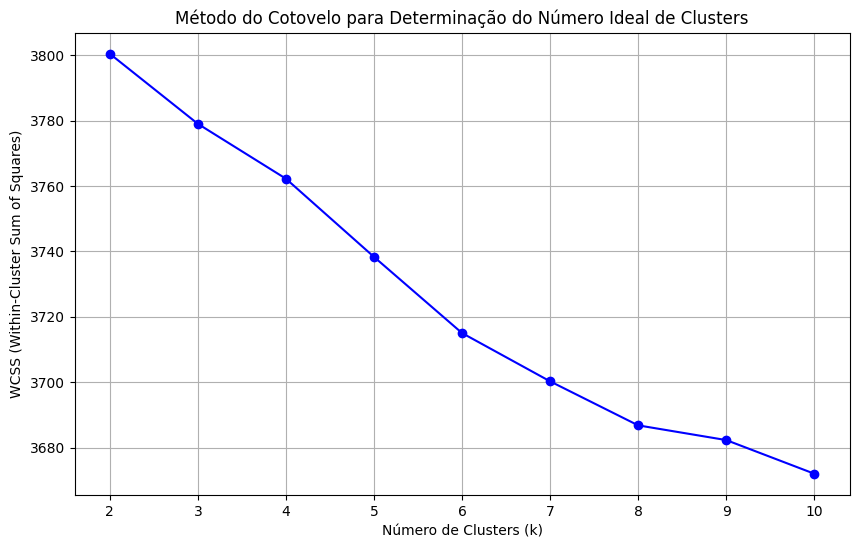

In [49]:
from sklearn.metrics import silhouette_score

# Método do Cotovelo - calcular WCSS para diferentes valores de k
wcss = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plotar o gráfico do cotovelo
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, "bo-")
plt.title("Método do Cotovelo para Determinação do Número Ideal de Clusters")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.grid(True)
plt.show()

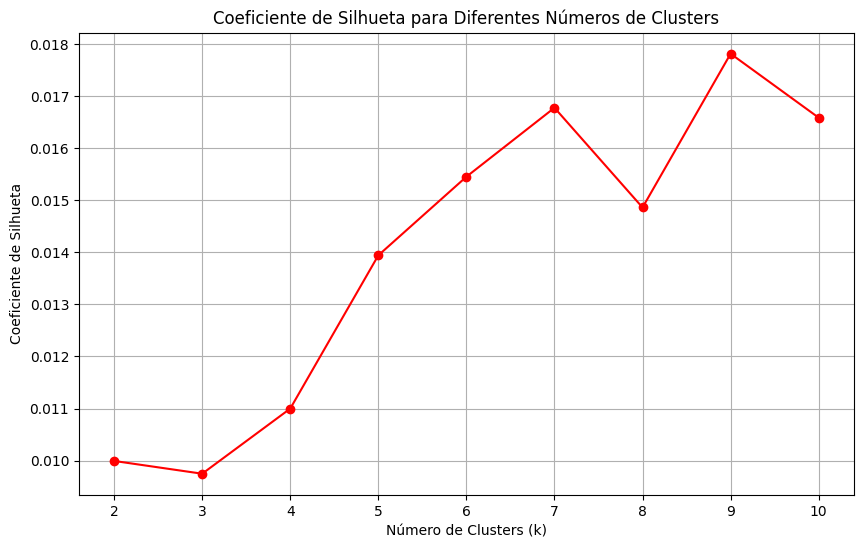

Melhor número de clusters (Silhueta): 9
Melhor coeficiente de silhueta: 0.018


In [50]:
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plotar coeficiente de silhueta
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, "ro-")
plt.title("Coeficiente de Silhueta para Diferentes Números de Clusters")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Coeficiente de Silhueta")
plt.grid(True)
plt.show()

# Encontrar o k com maior coeficiente de silhueta
best_k = k_range[silhouette_scores.index(max(silhouette_scores))]
print(f"Melhor número de clusters (Silhueta): {best_k}")
print(f"Melhor coeficiente de silhueta: {max(silhouette_scores):.3f}")

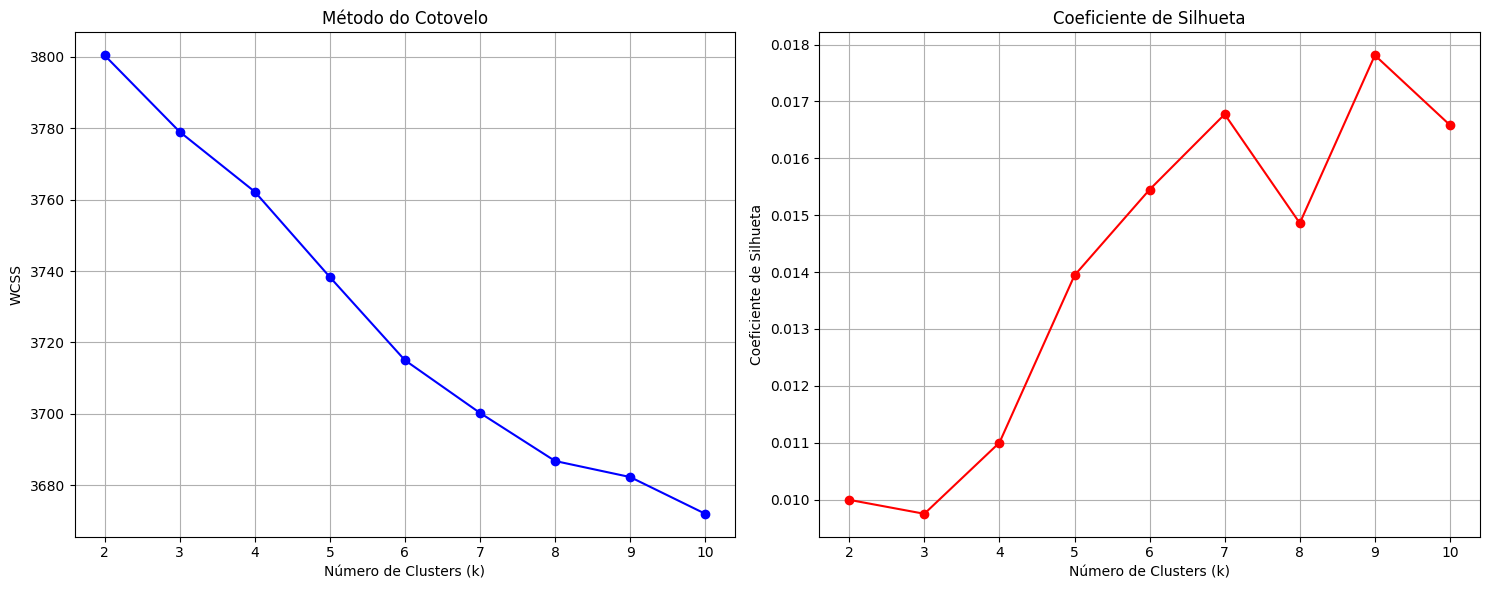

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Método do Cotovelo
ax1.plot(k_range, wcss, "bo-")
ax1.set_title("Método do Cotovelo")
ax1.set_xlabel("Número de Clusters (k)")
ax1.set_ylabel("WCSS")
ax1.grid(True)

# Coeficiente de Silhueta
ax2.plot(k_range, silhouette_scores, "ro-")
ax2.set_title("Coeficiente de Silhueta")
ax2.set_xlabel("Número de Clusters (k)")
ax2.set_ylabel("Coeficiente de Silhueta")
ax2.grid(True)

plt.tight_layout()
plt.show()

In [52]:
# Encontrar o "cotovelo" automaticamente
kl = KneeLocator(k_range, wcss, curve="convex", direction="decreasing")
elbow_k = kl.elbow

print(f"Número ideal de clusters (Cotovelo): {elbow_k}")
print(f"Melhor número de clusters (Silhueta): {best_k}")

# Comparar ambos os métodos
print(
    f"\nRecomendação final: considere k entre {min(elbow_k, best_k)} e {max(elbow_k, best_k)}"
)

Número ideal de clusters (Cotovelo): 6
Melhor número de clusters (Silhueta): 9

Recomendação final: considere k entre 6 e 9


In [53]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

# Calcular múltiplas métricas
results = []


for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X)

    silhouette = silhouette_score(X, cluster_labels)
    calinski = calinski_harabasz_score(X.toarray(), cluster_labels)
    davies = davies_bouldin_score(X.toarray(), cluster_labels)

    results.append(
        {
            "k": k,
            "silhouette": silhouette,
            "calinski_harabasz": calinski,
            "davies_bouldin": davies,
            "wcss": wcss[k - 2],  # Ajustar índice
        }
    )

results_df = pd.DataFrame(results)
print("Métricas de Avaliação por Número de Clusters:")
print(results_df.round(3))

Métricas de Avaliação por Número de Clusters:
    k  silhouette  calinski_harabasz  davies_bouldin      wcss
0   2       0.010             36.669           9.623  3800.433
1   3       0.010             29.540           7.658  3779.007
2   4       0.011             25.599           6.874  3762.229
3   5       0.014             25.576           6.166  3738.328
4   6       0.015             25.493           6.723  3715.038
5   7       0.017             23.926           6.087  3700.274
6   8       0.015             22.618           5.460  3686.816
7   9       0.018             20.408           6.708  3682.317
8  10       0.017             19.403           6.254  3672.031


In [54]:
# Análise automatizada para escolher melhor k
results_df["silhouette_rank"] = results_df["silhouette"].rank(ascending=False)
results_df["calinski_rank"] = results_df["calinski_harabasz"].rank(ascending=False)
results_df["davies_rank"] = results_df["davies_bouldin"].rank(
    ascending=True
)  # Menor é melhor

# Pontuação combinada (menor pontuação = melhor)
results_df["combined_rank"] = (
    results_df["silhouette_rank"]
    + results_df["calinski_rank"]
    + results_df["davies_rank"]
) / 3

# Mostrar ranking
print("Ranking Combinado das Métricas:")
print(
    results_df[
        ["k", "silhouette", "calinski_harabasz", "davies_bouldin", "combined_rank"]
    ].sort_values("combined_rank")
)

# Melhor k baseado no ranking combinado
best_k_combined = results_df.loc[results_df["combined_rank"].idxmin(), "k"]
print(f"\nMelhor número de clusters (ranking combinado): {best_k_combined}")

Ranking Combinado das Métricas:


    k  silhouette  calinski_harabasz  davies_bouldin  combined_rank
5   7    0.016775          23.926210        6.087016       3.333333
3   5    0.013942          25.576309        6.165767       4.333333
6   8    0.014860          22.618294        5.459963       4.333333
7   9    0.017813          20.407576        6.707579       4.666667
4   6    0.015451          25.492867        6.723051       5.000000
8  10    0.016585          19.403454        6.254083       5.333333
2   4    0.011000          25.599232        6.874470       5.666667
0   2    0.009994          36.668537        9.622748       6.000000
1   3    0.009749          29.540275        7.658254       6.333333

Melhor número de clusters (ranking combinado): 7


In [55]:
# Escolher número de clusters
k = int(best_k_combined)  # type: ignore
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(X)

# Exibir quantidade de títulos por cluster
df["cluster"].value_counts().sort_index()

cluster
0     227
1    2269
2     937
3      50
4      71
5     186
6     181
Name: count, dtype: int64

## 6. Visualizar e Analisar os Grupos Formados

Vamos reduzir a dimensionalidade dos vetores para 2D usando PCA ou t-SNE e visualizar os clusters.

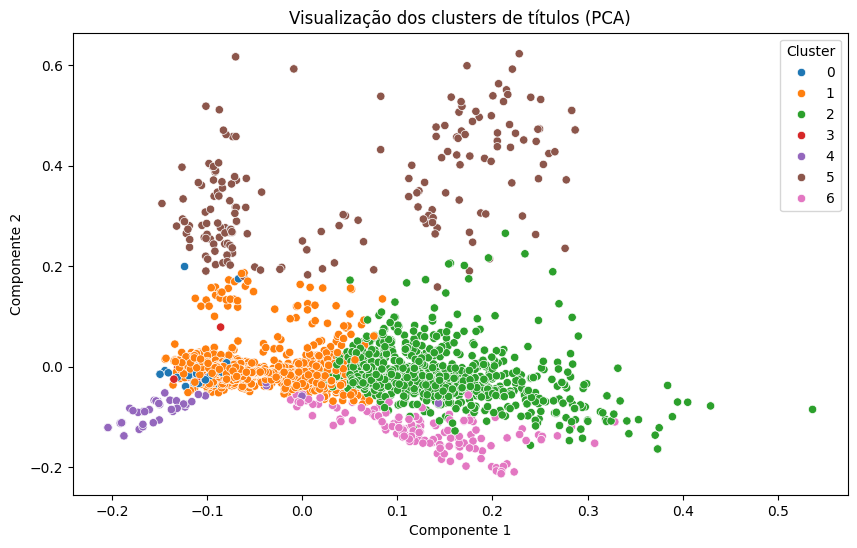

In [56]:
# Redução de dimensionalidade para visualização
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X.toarray())  # type: ignore

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1], hue=df["cluster"], palette="tab10", legend="full"
)
plt.title("Visualização dos clusters de títulos (PCA)")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.legend(title="Cluster")

# Redução de dimensionalidade para visualização
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X.toarray())  # type: ignore

fig = px.scatter_3d(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    z=X_pca[:, 2],
    color=df["cluster"].astype(str),
    hover_name=df["titulo"],
    hover_data={"titulo": df["titulo"]},
    title="Visualização dos clusters de títulos (PCA 3D)",
    color_discrete_sequence=px.colors.qualitative.Bold,
)
fig.update_traces(
    marker=dict(size=5, line=dict(width=0.5, color="black")),
    hovertemplate="<b>%{customdata}</b><extra></extra>",
    customdata=df["titulo"],
)
fig.show()

## 7. Exibir Exemplos de Títulos por Cluster

Vamos mostrar alguns exemplos de títulos agrupados por cluster para facilitar a interpretação dos temas de cada grupo.

In [57]:
# Exibir exemplos de títulos por cluster
for cluster_id in sorted(df["cluster"].unique()):
    print(f"\nCluster {cluster_id}:")
    exemplos = df[df["cluster"] == cluster_id]["titulo"].tolist()
    for exemplo in exemplos:
        print(f" - {exemplo}")

    with open(
        f"cluster_{cluster_id}_exemplos.txt", "w", encoding="utf-8"
    ) as f:  # salvando os clusters em arquivos para visualização
        f.write("\n".join(exemplos))


Cluster 0:
 - Um Sistema de Recomendação de Especialistas em Desenvolvimento Distribuído de Software:  Requisitos, Projeto e Resultados Preliminares. In: VI Simpósio Brasileiro de Sistemas Colaborativos, 2009, Fortaleza-CE. Anais do VI Simpósio Brasileiro de Sistemas Colaborativos, 2009.
 - Levantamento Estatístico Acerca da Disciplina de Estrutura de Dados no Curso de Bacharelado em Ciência da Computação da UFPB. In: XIV Encontro de Iniciação à Docência, 2011, João Pessoa. Anais do XIV Encontro de Iniciação à Docência. João Pessoa: Editora Universitária da UFPB, 2011.
 - Física de Sistemas Granulares: Criação de um Ambiente de Alto Desempenho Utilizando o Sistema Operacional Linux. In: XI Encontro de Iniciação Científica da UFPB, 2003, João Pessoa. XI Encontro de Iniciação Científica da UFPB. João Pessoa: Editora Universitária/UFPB, 2003. v. 1. p. 83-83.
 - Um Sistema de Recomendação de Especialistas em Desenvolvimento Distribuído de Software: Requisitos, Projeto e Resultados Prelimi